In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits

import time
import os
from pathlib import Path

import poppy

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
platform = jax.devices()[0].platform
device = jax.devices()[0].device_kind

print(f'Jax platform: {platform}')
print(f'Jax device: {device}')

import utils
import imshows
from imshows import *

wavelength = 633*u.nm
pupil_diam = 7.4*u.mm
fl = 150*u.mm
fnum = fl.to_value(u.mm)/pupil_diam.to_value(u.mm)

um_per_lamD = wavelength.to(u.um) * fnum
pixelscale_m = 3.45e-6
pixelscale_lamD = pixelscale_m / um_per_lamD.to_value(u.m)
print(pixelscale_m, pixelscale_lamD)

def pad_or_crop( arr_in, npix ):
    n_arr_in = arr_in.shape[0]
    if n_arr_in == npix:
        return arr_in
    elif npix < n_arr_in:
        x1 = n_arr_in // 2 - npix // 2
        x2 = x1 + npix
        arr_out = arr_in[x1:x2,x1:x2]
    else:
        arr_out = jnp.zeros((npix,npix), dtype=arr_in.dtype)
        x1 = npix // 2 - n_arr_in // 2
        x2 = x1 + n_arr_in
        arr_out = arr_out.at[x1:x2,x1:x2].set(arr_in)
    return arr_out

def crop(im, xc,yc,nim):
    return im[xc-nim//2:xc+nim//2, yc-nim//2:yc+nim//2]

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe
3.45e-06 0.26887835703001584


In [3]:
npix = 512
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1)
ap = poppy.NgonAperture(nsides=14, radius=pupil_diam/2, rotation=0.5).get_transmission(wf)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [4]:
utils.save_fits(f'aperture_14_{npix:d}.fits', ap.get())

Saved data to:  aperture_14_512.fits


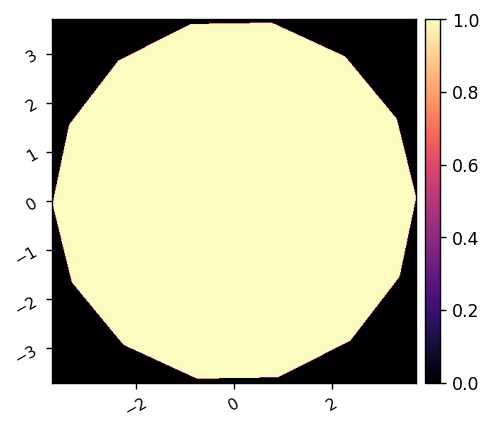

In [2]:
npix = 512
ap = jnp.asarray(fits.getdata(f'aperture_14_{npix:d}.fits'))
imshow1(ap, pxscl=pupil_diam/npix)

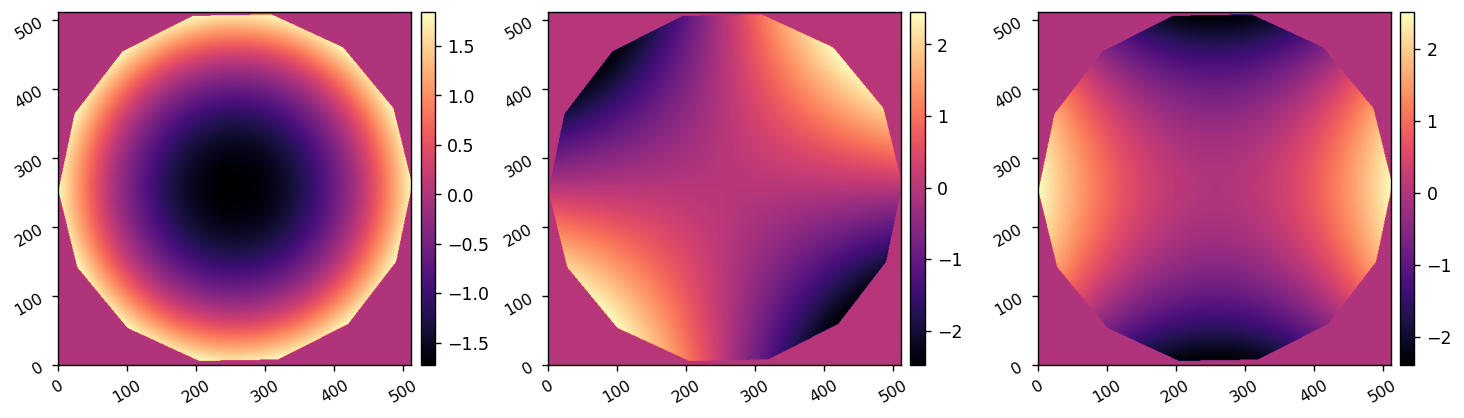

In [3]:
nmodes = 25
zmodes = jnp.asarray(poppy.zernike.arbitrary_basis(ap, nterms=nmodes+3, outside=0)[3:].get())
modes = zmodes.reshape(nmodes, npix**2).T
imshow3(zmodes[0], zmodes[1], zmodes[2])

# Initialize the model, calculate the PSFs, do the estimation

In [4]:
import estimation
import model

wavelengths = jnp.array([wavelength.to_value(u.m)])
spectrum = jnp.linspace(1, 1, num=1)

In [11]:
long_defocus = [3e-3, 1e-3, -2e-3, -4e-3]
nim = 128
mod = model.ForwardModel(npix, nim, fnum, pixelscale_m, 
                           wavelength.to_value(u.m), wavelengths, 
                           long_defocus, 
                        #    spectrum=spectrum, 
                           )


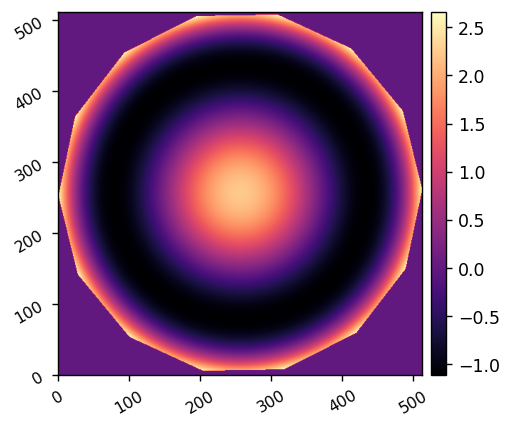

In [6]:
imshow1(zmodes[7])

In [28]:
modes.shape

(262144, 25)

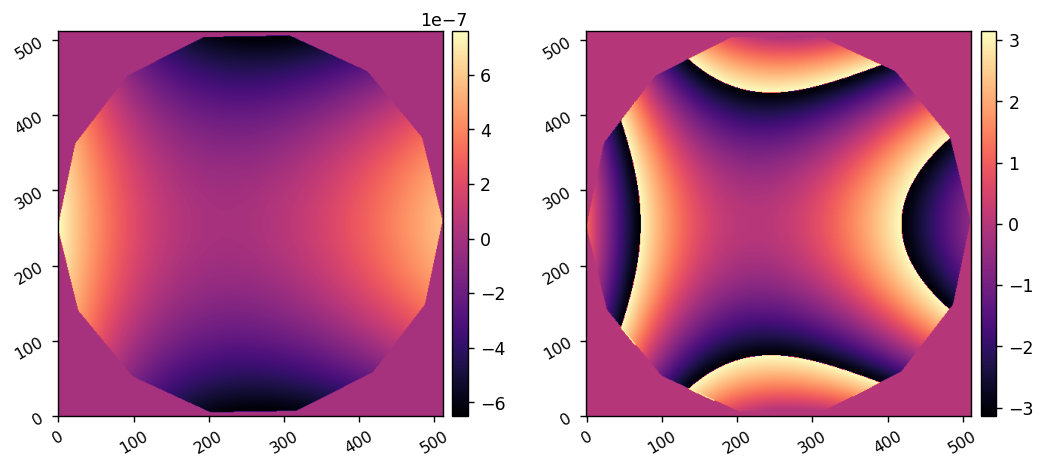

In [12]:
# np.random.seed(123)
# a = 3e-9 * np.random.randn(nmodes)
# a[0] = 0 # just set the defocus coefficient to 0

a = np.zeros(nmodes)
a[0] = -0.00807947 * wavelength.to_value(u.m)
a[2] = 0.42132392 * wavelength.to_value(u.m)
a[4] = 0.04698882 * wavelength.to_value(u.m)
a[6] = 0.00044749 * wavelength.to_value(u.m)
a[7] = 0.00267972 * wavelength.to_value(u.m)
# a[] = * wavelength.to_value(u.m)
wfe = jnp.rot90(jnp.rot90(modes.dot(a).reshape(npix,npix)))
pupil = ap*jnp.exp(1j*2*np.pi*wfe/wavelength.to_value(u.m))
imshow2(wfe, np.asarray(jnp.angle(pupil)))

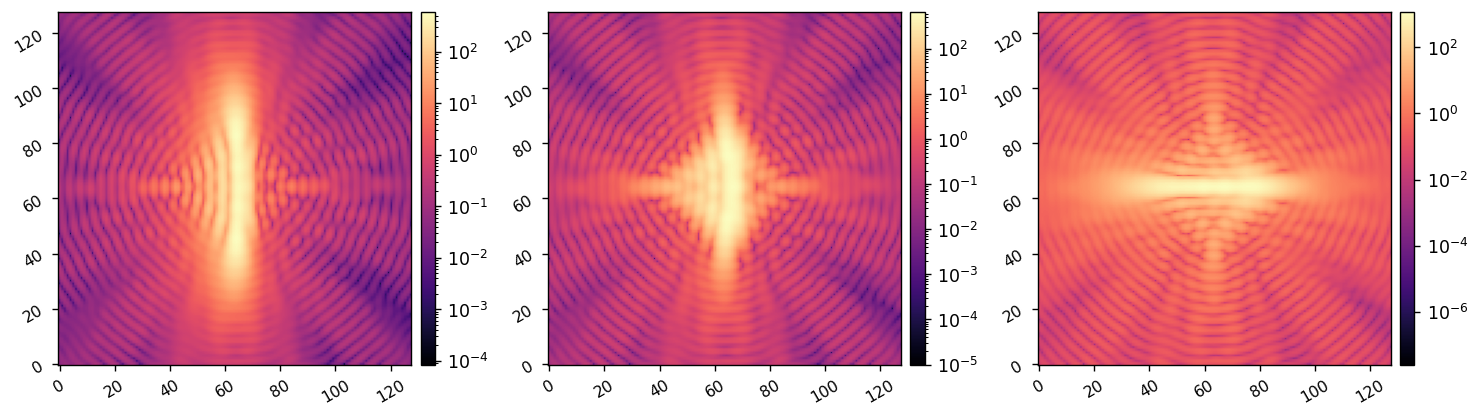

In [13]:
psfs = model.forward_propagate(ap, wfe, mod.wavelengths, mod.fresnel_TFs, mod.Mx, mod.My)
imshow3(psfs[0], psfs[1], psfs[2], lognorm=True)

In [14]:
# estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=1000, wreg=1e-10)
# estimator = estimation.Estimation(mod, estimate_phase=True, estimate_amplitude=True, maxiter=100, wreg=1e-2)

estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=100, wreg=1e-5,
                                  phase_modal=True, 
                                  modes=zmodes)

In [15]:
fit, err, objvals = estimator.run(psfs, ap)

(512, 512)
(512, 128)
(128, 512)


2024-05-08 08:07:19.423755: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.8821377421658373 Stepsize:1.0  Decrease Error:0.8821377421658373  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.8787858847488661 Stepsize:0.4999999999997712  Decrease Error:0.8787858847488661  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 0.8799578721157763 Stepsize:0.2113248654048273  Decrease Error:0.8799578721157763  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.8814823403625883 Stepsize:0.09219614418894778  Decrease Error:0.8814823403625883  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 0.8816243870040312 Stepsize:0.040004514619656484  Decrease Error:0.8816243870040312  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decreas

2024-05-08 08:07:29.891022: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Err

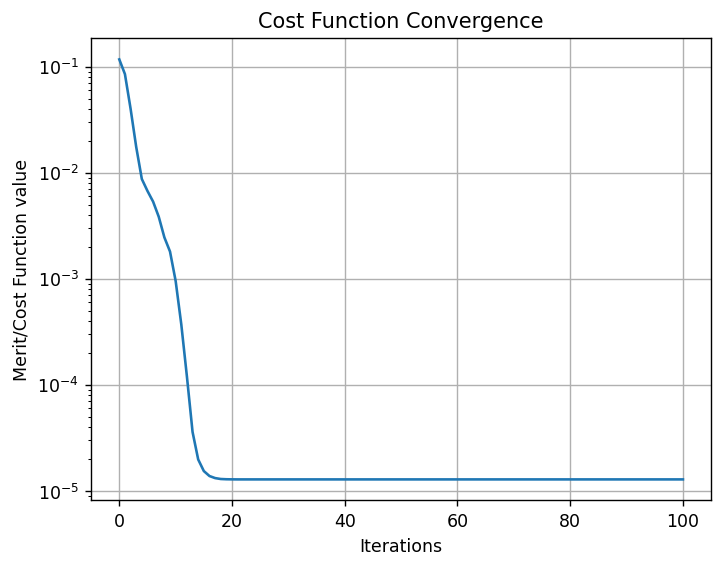

In [19]:
plt.figure(dpi=125)
plt.semilogy(objvals)
plt.title('Cost Function Convergence')
plt.xlabel('Iterations')
plt.ylabel('Merit/Cost Function value')
plt.grid()

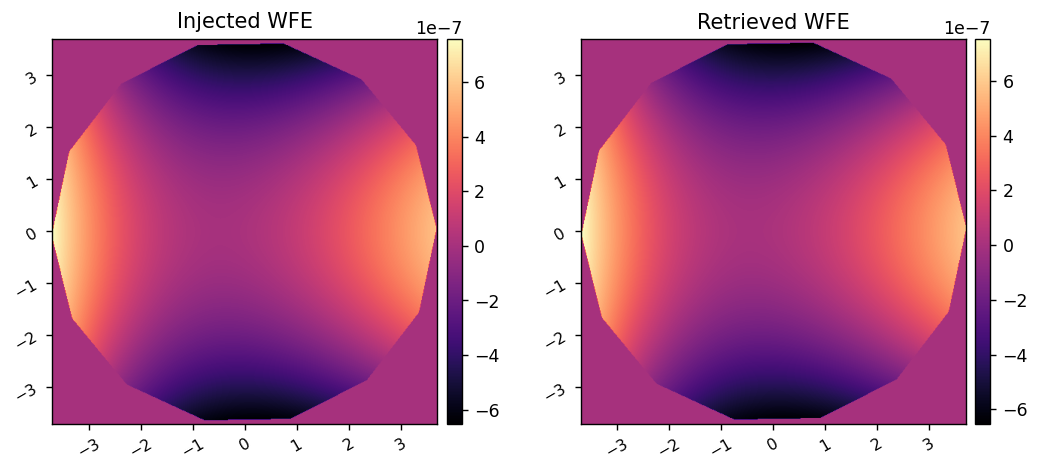

In [18]:
# opd_est = modes.dot(fit[-1]).reshape(npix,npix)
# est_wfe = ap*(opd_est)
# diff = est_wfe-wfe
# imshow3(est_wfe, wfe, diff, vmin1=jnp.min(wfe), vmax1=jnp.max(wfe))

opd_est = modes.dot(fit[-1]).reshape(npix,npix)
est_wfe = ap*(opd_est)
diff = est_wfe-wfe
imshow2(wfe, est_wfe,
        'Injected WFE', 'Retrieved WFE',
        vmin1=jnp.min(wfe), vmax1=jnp.max(wfe),
        pxscl=pupil_diam/npix)
